<a href="https://colab.research.google.com/github/EmKelsall/ADS2002---Catheter-Placement-Project/blob/main/ResNet%20-%20ETT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet - ETT

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from PIL import Image
import ast
import os
import cv2
from tqdm import tqdm

In [ ]:
train_data = pd.read_csv("/kaggle/input/ranzcr-clip-catheter-line-classification/train.csv")
train_data = train_data[(train_data['ETT - Borderline'] != 1 )]

train_data[['ETT - Normal', 'ETT - Abnormal', 'ETT - Borderline']].value_counts()
train_data['ETT - Present'] = np.where((train_data['ETT - Normal'] == 0) & (train_data['ETT - Abnormal'] == 0) & (train_data['ETT - Borderline'] == 0), 0, 1)

train_data[['ETT - Normal', 'ETT - Abnormal']].value_counts()

ETT - Normal  ETT - Abnormal
0             0                 21626
1             0                  7240
0             1                    79
Name: count, dtype: int64

In [ ]:
normalAb = pd.concat([train_data[train_data['ETT - Normal'] == 1].sample(n=39), train_data[train_data['ETT - Abnormal'] == 1].sample(n=39)])
sampled_data = pd.concat([normalAb, train_data[train_data['ETT - Present'] == 0].sample(n=78)])

sampled_data

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,ETT - Present
18335,1.2.826.0.1.3680043.8.498.12808251684309131301...,0,0,1,0,0,0,0,0,0,1,0,3fb755940,1
16818,1.2.826.0.1.3680043.8.498.64545344928474329458...,0,0,1,0,0,0,1,0,0,1,0,25590bd5f,1
2370,1.2.826.0.1.3680043.8.498.95430425383132004650...,0,0,1,0,0,0,0,0,0,1,0,dff1c0f73,1
25211,1.2.826.0.1.3680043.8.498.10480044806634047819...,0,0,1,0,0,0,0,0,0,1,0,4da1ef00e,1
27722,1.2.826.0.1.3680043.8.498.13373062361633258041...,0,0,1,0,0,1,0,0,0,1,0,a7afe075d,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23460,1.2.826.0.1.3680043.8.498.10383526461057115729...,0,0,0,0,0,0,0,0,0,1,0,cc1277177,0
11622,1.2.826.0.1.3680043.8.498.53392761555531684084...,0,0,0,0,0,0,0,0,0,1,0,dd4b69482,0
12896,1.2.826.0.1.3680043.8.498.12835091123305319564...,0,0,0,0,0,0,0,0,0,1,0,57eae9725,0
15818,1.2.826.0.1.3680043.8.498.75375541699770932705...,0,0,0,0,0,0,0,0,0,1,0,bc6b7ac06,0


In [ ]:
def getFileNames(df):
    studyInstance = df['StudyInstanceUID'].tolist()
    studyInstance

    for i in range(len(studyInstance)):
        studyInstance[i] = f'{studyInstance[i]}.jpg'

    return studyInstance

In [ ]:
studyInstance = getFileNames(sampled_data)

In [ ]:
def processImages(filenames,train_test):

    imgs = []
    FileIDs = []
    lst = []


    desired_channels = 3

    count = 0
    for file in tqdm(filenames, position=0, leave=True):
        # Making sure the images are the same pixel size
        img = Image.open(f"/kaggle/input/ranzcr-clip-catheter-line-classification/{train_test}/{file}")
        img = img.resize((300, 300))
        img = np.array(img)

        # Ensure that the image has 3 channels (RGB)
        if img.shape[-1] != 3:
            img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB by duplicating channels

        imgs.append(img)  # Append the 4D image to the list

        # Save filename for later
        FileIDs.append(file)

        count += 1

    # Convert the list of images to a numpy array
    imgs = np.array(imgs)
    return imgs, FileIDs

In [ ]:
train_imgs, fileIDs = processImages(studyInstance, 'train')

100%|██████████| 156/156 [00:09<00:00, 16.39it/s]


In [ ]:
#cleaning up the labels
UID = []
for i in range(len(fileIDs)):
  UID.append(fileIDs[i].replace(".jpg",""))

UID[0:10]

['1.2.826.0.1.3680043.8.498.12808251684309131301583755654824541840',
 '1.2.826.0.1.3680043.8.498.64545344928474329458810362248833710064',
 '1.2.826.0.1.3680043.8.498.95430425383132004650191433607630505062',
 '1.2.826.0.1.3680043.8.498.10480044806634047819626681796785825533',
 '1.2.826.0.1.3680043.8.498.13373062361633258041199854131744962522',
 '1.2.826.0.1.3680043.8.498.28300964548658894395744362436309385737',
 '1.2.826.0.1.3680043.8.498.59297302149458774284162472548980015632',
 '1.2.826.0.1.3680043.8.498.27638524618188151587003689152335998105',
 '1.2.826.0.1.3680043.8.498.13028010645410161954037386970470767950',
 '1.2.826.0.1.3680043.8.498.92346044940481053670973987722867427355']

In [ ]:
columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal', 'CVC - Normal']

ETTsampled_data = sampled_data.drop(columns=columns_to_drop, axis=1)

ETTsampled_data.set_index('StudyInstanceUID', inplace=True)

In [ ]:
train_labels_df = np.empty((0,3))
data = []

for ID in UID:
    data.append(ETTsampled_data.loc[ID])

train_labels_df = pd.DataFrame(data)

train_labels_df = train_labels_df.reindex(UID)
train_labels = train_labels_df['ETT - Present'].values
train_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

# Split your data into training and temporary data (combined validation and test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [ ]:
def buildTrainData(catheter, train_data, size):

    train_data = train_data[train_data[f'{catheter} - Present'] == 1]
    train_data = train_data = train_data[~((train_data[f'{catheter} - Normal'] == 1) & (train_data[f'{catheter} - Abnormal'] == 1))]
    train_data[f'{catheter} - Normal/Abnormal'] = np.where(train_data[f'{catheter} - Normal'] == 1, 1, 0)
    sampled_data = pd.concat([train_data[train_data[f'{catheter} - Normal'] == 1].sample(n=size), train_data[train_data[f'{catheter} - Abnormal'] == 1].sample(n=size)])

    return sampled_data

In [ ]:
sample = buildTrainData('ETT', train_data, 78)
sample

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,ETT - Present,ETT - Normal/Abnormal
29887,1.2.826.0.1.3680043.8.498.36518875504968416477...,0,0,1,0,0,0,1,1,0,0,0,83f1d2141,1,1
6375,1.2.826.0.1.3680043.8.498.13181424540386334611...,0,0,1,0,0,0,1,0,0,1,1,ca9a05f60,1,1
29672,1.2.826.0.1.3680043.8.498.10815368909177631498...,0,0,1,0,0,1,0,0,1,0,0,2bb41c720,1,1
14805,1.2.826.0.1.3680043.8.498.13221541665973093351...,0,0,1,0,0,1,0,0,1,0,0,41320a953,1,1
5196,1.2.826.0.1.3680043.8.498.50626675605939419196...,0,0,1,0,0,0,1,0,0,1,0,fd3ab6f0e,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20701,1.2.826.0.1.3680043.8.498.10479615105716260873...,1,0,0,0,0,0,0,0,1,0,0,b478001d5,1,0
18286,1.2.826.0.1.3680043.8.498.45630226598251928362...,1,0,0,0,0,0,1,0,1,0,0,bf4c6da3c,1,0
23435,1.2.826.0.1.3680043.8.498.80937139423520710449...,1,0,0,0,0,0,1,0,0,1,0,3fb755940,1,0
5457,1.2.826.0.1.3680043.8.498.30836180807940123518...,1,0,0,0,0,0,0,0,0,1,0,2fcdd13f8,1,0


In [ ]:
nAb_data = getFileNames(sample)
ett_imgs, fileIDs = processImages(nAb_data, 'train')

100%|██████████| 156/156 [00:08<00:00, 18.49it/s]


In [ ]:
UID = []
for i in range(len(fileIDs)):
  UID.append(fileIDs[i].replace(".jpg",""))

columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal', 'CVC - Normal', 'ETT - Present']

ETTsample = sample.drop(columns=columns_to_drop, axis=1)
ETTsample.set_index('StudyInstanceUID', inplace=True)

ETTsample

,ETT - Normal/Abnormal
StudyInstanceUID,
1.2.826.0.1.3680043.8.498.36518875504968416477207111692632539562,1
1.2.826.0.1.3680043.8.498.13181424540386334611112176122756730652,1
1.2.826.0.1.3680043.8.498.10815368909177631498970268684837832051,1
1.2.826.0.1.3680043.8.498.13221541665973093351408354838592188322,1
1.2.826.0.1.3680043.8.498.50626675605939419196753481286642152534,1
...,...
1.2.826.0.1.3680043.8.498.10479615105716260873080198321864360531,0
1.2.826.0.1.3680043.8.498.45630226598251928362902318654119069919,0
1.2.826.0.1.3680043.8.498.80937139423520710449087164918249582817,0


In [ ]:
train_labels_df = np.empty((0,3))
data = []

for ID in UID:
    data.append(ETTsample.loc[ID])

train_labels_df = pd.DataFrame(data)

train_labels_df = train_labels_df.reindex(UID)
ett_labels = train_labels_df['ETT - Normal/Abnormal'].values
ett_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

# Split your data into training and temporary data (combined validation and test)
trainETT_imgs, temp_imgs, trainETT_labels, temp_labels = train_test_split(ett_imgs, ett_labels, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets
valETT_imgs, testETT_imgs, valETT_labels, testETT_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

In [ ]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False)

# Add dropout and batch normalization to custom fully connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# First Output Branch: CVC Catheter Presence (Binary Classification)
output_ETTpresent = Dense(1, activation='sigmoid', name='output_ETTpresent')(x)

# Add a separate set of layers for the new task
y = base_model.output
y = GlobalAveragePooling2D()(y)
y = Dense(1024, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)

# Second Output Branch: CVC Placement (Binary Classification)
output_ett_placement = Dense(1, activation='sigmoid', name='output_ETTnormalAbnormal')(y)

# Combine the two output branches
combined_model = Model(inputs=base_model.input, outputs=[output_ETTpresent, output_ett_placement])

# Compile the combined model with optimizer and loss functions for both tasks
combined_model.compile(optimizer='SGD',
                       loss={'output_ETTpresent': 'binary_crossentropy', 'output_ETTnormalAbnormal': 'binary_crossentropy'},
                       metrics={'output_ETTpresent': 'accuracy', 'output_ETTnormalAbnormal': 'accuracy'})

# # Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model during training
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = combined_model.fit(
    {'input_1': train_imgs},
    {'output_ETTpresent': train_labels, 'output_ETTnormalAbnormal': trainETT_labels},
    epochs=30,
    validation_data=(
        {'input_1': val_imgs},
        {'output_ETTpresent': val_labels, 'output_ETTnormalAbnormal': valETT_labels}
    ),
    callbacks=[reduce_lr, early_stop, model_checkpoint]
)

94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/30
4/4 [==============================] - 96s 21s/step - loss: 1.5294 - output_ETTpresent_loss: 0.7815 - output_ETTnormalAbnormal_loss: 0.7478 - output_ETTpresent_accuracy: 0.6048 - output_ETTnormalAbnormal_accuracy: 0.6290 - val_loss: 1.4038 - val_output_ETTpresent_loss: 0.7199 - val_output_ETTnormalAbnormal_loss: 0.6839 - val_output_ETTpresent_accuracy: 0.3125 - val_output_ETTnormalAbnormal_accuracy: 0.5625 - lr: 0.0100
Epoch 2/30
4/4 [==============================] - 83s 21s/step - loss: 0.5241 - output_ETTpresent_loss: 0.2532 - output_ETTnormalAbnormal_loss: 0.2709 - output_ETTpresent_accuracy: 0.8952 - output_ETTnormalAbnormal_accuracy: 0.8710 - val_loss: 1.3186 - val_output_ETTpresent_loss: 0.6268 - val_output_ETTnormalAbnormal_loss: 0.6917 - val_output_ETTpresent_accuracy: 0.6875 - val_output_ETTnormalAbnormal_accuracy: 0.6250 - lr: 0.0100
Epoch 3/30
4/4 [==============================] - 84s 21s/step - lo

In [ ]:
# Evaluate accuracy for the 'output_catheter' branch
evaluation = combined_model.evaluate(
    {'input_1': test_imgs},
    {'output_ETTpresent': test_labels, 'output_ETTnormalAbnormal': testETT_labels},
)

# Extract the accuracy values from the evaluation results
test_accuracy_catheter = evaluation[3]  # Index 3 corresponds to 'output_catheter_accuracy'
test_accuracy_cvc_placement = evaluation[4]  # Index 4 corresponds to 'output_cvc_placement_accuracy'

print(f'Test Accuracy (ETT Present): {test_accuracy_catheter * 100:.2f}%')
print(f'Test Accuracy (ETT Normal/Abnormal): {test_accuracy_cvc_placement * 100:.2f}%')

1/1 [==============================] - 2s 2s/step - loss: 1.1538 - output_ETTpresent_loss: 0.5100 - output_ETTnormalAbnormal_loss: 0.6438 - output_ETTpresent_accuracy: 0.7500 - output_ETTnormalAbnormal_accuracy: 0.6250
Test Accuracy (ETT Present): 75.00%
Test Accuracy (ETT Normal/Abnormal): 62.50%


In [ ]:
test_path = "/kaggle/input/ranzcr-clip-catheter-line-classification/test"

all_files = os.listdir(test_path)

test_files = all_files[:300]

In [ ]:
test_img, testFiles = processImages(test_files, "test")


100%|██████████| 300/300 [00:26<00:00, 11.37it/s]


1/1 [==============================] - 7s 7s/step


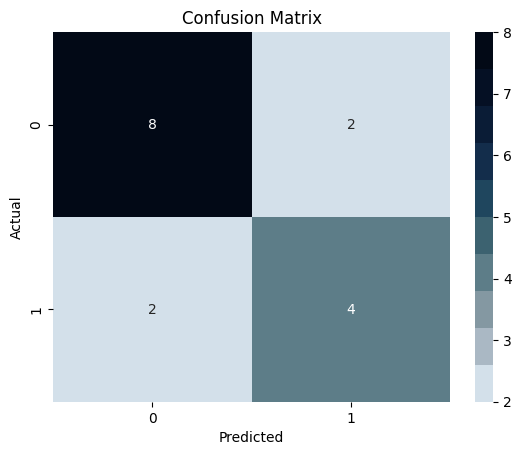

In [ ]:
predictions = combined_model.predict(test_imgs)
predictions

# Access predictions for the first task
ngt_present_predictions = predictions[0]
ngt_present_predictions
# Access predictions for the second task
ngt_normal_abnormal_predictions = predictions[1]

ngt_present_predictions
# Create two separate DataFrames
df1 = pd.DataFrame(ngt_present_predictions, columns=["ETT - Present"])
df2 = pd.DataFrame(ngt_normal_abnormal_predictions, columns=['ETT - Normal/Abnormal'])

# # Concatenate the DataFrames horizontally to create one with two columns
NGTpredictions = pd.concat([df1, df2], axis=1)
NGTpredictions

NGTpredictions['ETT - Present'] = np.where(NGTpredictions['ETT - Present'] > 0.5, 1, 0)
NGTpredictions['ETT - Normal/Abnormal'] = np.where(NGTpredictions['ETT - Normal/Abnormal'] > 0.5, 1, 0)
NGTpredictions

from sklearn.metrics import confusion_matrix

# Create the confusion matrix
confusion_matrix_present = confusion_matrix(test_labels, NGTpredictions['ETT - Present'])

plt.gca().patch.set_facecolor('none')



custom_palette = ['#D3E0EA', '#AAB8C4', '#8498A2', '#5D7D88', '#3C6270',
                  '#1F465E', '#132D4B', '#0A1C36', '#051024', '#020916']

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix_present, annot=True, cmap=custom_palette)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

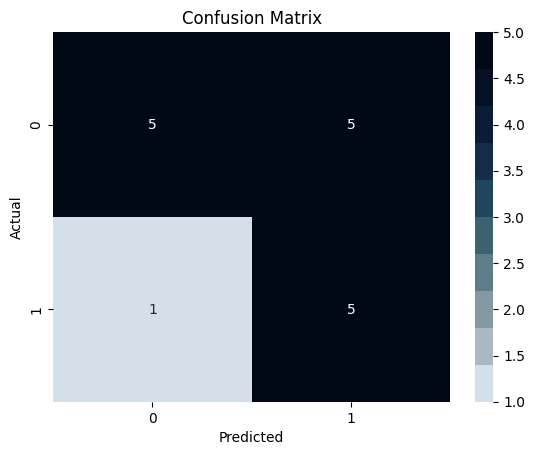

In [ ]:
confusion_matrix_present = confusion_matrix(test_labels, NGTpredictions['ETT - Normal/Abnormal'])

plt.gca().patch.set_facecolor('none')



custom_palette = ['#D3E0EA', '#AAB8C4', '#8498A2', '#5D7D88', '#3C6270',
                  '#1F465E', '#132D4B', '#0A1C36', '#051024', '#020916']

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix_present, annot=True, cmap=custom_palette)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()